In [21]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback

from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import talos
from talos.model.normalizers import lr_normalizer

In [4]:
df = pd.read_csv('l_h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria


In [5]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(8100, 300)

In [6]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [7]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [8]:
y

array([ 0,  0,  0, ..., 25, 25, 25])

In [9]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [10]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [11]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [12]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [13]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

In [14]:
randomInit = initializers.RandomUniform(seed=42)

In [33]:
def find_the_best(x_train, y_train, x_val, y_val, params):

##### NEW

    model = Sequential()

    model.add(LSTM(params['first_neuron'], kernel_initializer = randomInit, bias_initializer = randomInit,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    
    #talos.utils.hidden_layers(model, params, 3)
    model.add(Dropout(params['dropout']))
    #model.add(Embedding(input_dim=301, output_dim=27)) # 100000 is the vocab size, 128 is arbitrary
    model.add(Dense(Y_train.shape[1], activation=params['last_activation']))

    #nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    #model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],#(lr=lr_normalizer(params['lr'], params['optimizer']),
                  metrics=['acc', talos.utils.metrics.f1score])
    #print(model.summary())
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)
    
    

    
    return history, model

In [59]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[16,32,64,128],
     'hidden_layers':[0, 1, 2,3, 4,5,6],
     'batch_size': [5,10,25,50],
     'epochs': [10,20,30],
     'dropout': (0, 0.40,2, 4,10),
     'lr':[0.1,0.01,0.001],
     #'kernel_initializer': ['uniform','normal'],
     'optimizer': ['Nadam', 'Adam',"Adamax","Adadelta","Adagrad","RMSprop","SGD"],
     'losses': ['categorical_crossentropy'],
     'activation':['relu', 'elu', "softmax" , "selu", "softplus", "softsign", "tanh", "sigmoid", "hard_sigmoid", "exponential", "linear"],
     'last_activation': ['softmax']}

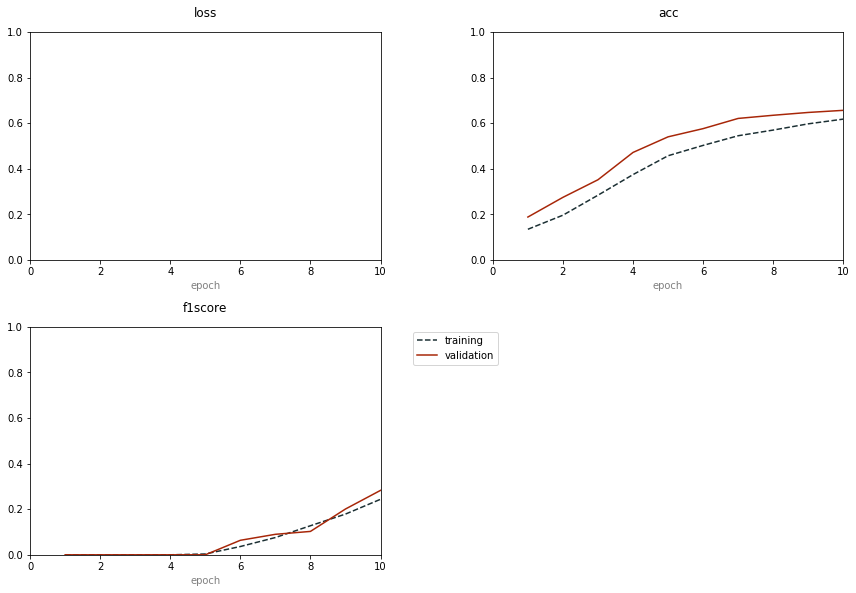









100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:04<00:00, 41.44s/it]


In [60]:
# and run the experiment
t = talos.Scan(x=X_train,
               y=Y_train,
               model=find_the_best,
               params=p,
               experiment_name='find_the_best',
               round_limit=100)

In [61]:
t.data

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer
0,30,0.919193,0.750000,0.618227,0.952065,0.740741,0.614157,softsign,50,0.0,30,16,5,softmax,categorical_crossentropy,0.010,Adamax
1,30,0.298065,0.873971,0.863314,0.369382,0.860670,0.847572,linear,10,0.2,30,32,3,softmax,categorical_crossentropy,0.100,Adam
2,20,1.171706,0.724280,0.393703,1.302224,0.649912,0.372585,selu,50,0.2,20,16,0,softmax,categorical_crossentropy,0.010,RMSprop
3,10,1.547021,0.610597,0.129046,1.574374,0.613757,0.127748,elu,5,0.0,10,16,5,softmax,categorical_crossentropy,0.001,Adagrad
4,30,0.201450,0.903292,0.901335,0.232921,0.891975,0.889241,softplus,5,0.2,30,64,3,softmax,categorical_crossentropy,0.001,Adam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,0.433377,0.843107,0.823682,0.457308,0.834656,0.822573,softplus,10,0.0,30,32,5,softmax,categorical_crossentropy,0.001,Adamax
96,20,0.317020,0.867798,0.866512,0.333124,0.876323,0.867286,relu,25,0.0,20,128,0,softmax,categorical_crossentropy,0.010,Adam
97,10,3.213871,0.253601,0.000000,3.217178,0.254850,0.000000,relu,10,0.2,10,64,1,softmax,categorical_crossentropy,0.100,SGD
98,30,0.460231,0.835905,0.810857,0.545109,0.811287,0.791109,hard_sigmoid,10,0.2,30,32,3,softmax,categorical_crossentropy,0.100,Adadelta


In [62]:
df=t.data

In [63]:
df.to_csv('data.csv')  

In [4]:
import pandas as pd
df = pd.read_csv('data.csv' )

In [21]:
df.head(50)

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer
0,0,30,0.919193,0.750000,0.618227,0.952065,0.740741,0.614157,softsign,50,0.0,30,16,5,softmax,categorical_crossentropy,0.010,Adamax
1,1,30,0.298065,0.873971,0.863314,0.369382,0.860670,0.847572,linear,10,0.2,30,32,3,softmax,categorical_crossentropy,0.100,Adam
2,2,20,1.171706,0.724280,0.393703,1.302224,0.649912,0.372585,selu,50,0.2,20,16,0,softmax,categorical_crossentropy,0.010,RMSprop
3,3,10,1.547021,0.610597,0.129046,1.574374,0.613757,0.127748,elu,5,0.0,10,16,5,softmax,categorical_crossentropy,0.001,Adagrad
4,4,30,0.201450,0.903292,0.901335,0.232921,0.891975,0.889241,softplus,5,0.2,30,64,3,softmax,categorical_crossentropy,0.001,Adam
5,5,20,0.388188,0.852366,0.849394,0.436741,0.839727,0.831194,exponential,5,0.2,20,64,3,softmax,categorical_crossentropy,0.001,RMSprop
6,6,20,3.252050,0.212449,0.000000,3.250037,0.181437,0.000000,selu,25,0.2,20,32,6,softmax,categorical_crossentropy,0.100,SGD
7,7,10,0.787146,0.780864,0.679515,0.892992,0.742725,0.643693,softplus,25,0.2,10,32,5,softmax,categorical_crossentropy,0.010,Adam
8,8,10,0.841300,0.783436,0.677695,0.901977,0.767857,0.647758,elu,50,0.0,10,16,5,softmax,categorical_crossentropy,0.010,Nadam
9,9,30,0.176669,0.905350,0.904207,0.195699,0.902998,0.902986,elu,5,0.2,30,128,2,softmax,categorical_crossentropy,0.010,Adam


In [20]:
df.tail(-50)

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer
50,50,10,0.310333,0.875514,0.866490,0.395362,0.849647,0.837480,exponential,5,0.2,10,32,1,softmax,categorical_crossentropy,0.010,Nadam
51,51,20,0.311218,0.872942,0.866684,0.331163,0.877645,0.865182,exponential,50,0.0,20,64,0,softmax,categorical_crossentropy,0.010,Nadam
52,52,20,3.267373,0.168210,0.000000,3.264940,0.181878,0.000000,linear,50,0.0,20,64,3,softmax,categorical_crossentropy,0.100,SGD
53,53,20,0.611723,0.789609,0.775542,0.683515,0.774471,0.751053,elu,50,0.2,20,64,2,softmax,categorical_crossentropy,0.001,Adadelta
54,54,20,0.834765,0.766975,0.662764,0.899848,0.738536,0.653120,selu,50,0.2,20,64,0,softmax,categorical_crossentropy,0.001,Adagrad
55,55,10,3.271152,0.166667,0.000000,3.269151,0.188933,0.000000,softsign,25,0.0,10,64,2,softmax,categorical_crossentropy,0.001,SGD
56,56,10,1.703885,0.605967,0.102302,1.800833,0.536596,0.089517,exponential,10,0.2,10,16,5,softmax,categorical_crossentropy,0.010,Adagrad
57,57,30,0.445519,0.844136,0.819052,0.523338,0.816578,0.789595,softplus,5,0.2,30,32,4,softmax,categorical_crossentropy,0.001,Adamax
58,58,30,0.293978,0.875514,0.862192,0.372052,0.857804,0.845098,softplus,10,0.2,30,32,1,softmax,categorical_crossentropy,0.100,Adam
59,59,10,1.005644,0.723765,0.563293,1.067845,0.703263,0.559790,tanh,25,0.2,10,64,6,softmax,categorical_crossentropy,0.001,Adagrad
